- Metrical form
- Look up most frequent trigrams 
- Look up most frequent words
- Fightin Words  
- Coefficient from PCA matrix factorization for each trigram
- Random groups

Why is franco easy to distinguish vs all the others and is it the same thing as why PCA groups FRanco and unknown vs everyone else (MATHEMATICALLY)

In [1]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import glob
import re
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations, product

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize

In [5]:
incerto_dir = '/content/drive/MyDrive/incerto-autore/'
new_poems_dir = os.path.join(incerto_dir, 'data', 'poems')
figures_dir = os.path.join(incerto_dir, 'figures', 'dimension-reduction')
output_dir = os.path.join(incerto_dir, 'output')

## Set up

In [6]:
df_d = {'Whole': pd.read_csv(os.path.join(new_poems_dir, 'poems_whole.csv')),
        'Split': pd.read_csv(os.path.join(new_poems_dir, 'poems_split.csv'))}

In [7]:
methods_d = {'UMAP': umap.UMAP(n_components=2),
             't-SNE': TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3),
             'PCA': PCA(n_components=2)
}

In [8]:
def apply_scaler(_norm, matrix):

    if _norm == 'StandardScaler':
        scaled = StandardScaler().fit_transform(matrix.toarray())
  # elif _norm == 'RobustScaler':
  #   scaled = RobustScaler().fit_transform(matrix.toarray())
    elif _norm == 'L1' or _norm == 'L2':
        scaled = normalize(matrix.toarray(), norm=_norm.lower(), axis=1)

    return scaled

In [9]:
def build_vectorizer(_typ, _ngram):

    if _typ == 'Count':
        vec = CountVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2])

    elif _typ == 'TfIdf':
        vec = TfidfVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2])
    return vec

In [10]:
variety = {'df':['Split', 'Whole'],
           'method': ['UMAP', 't-SNE'],# 'PCA'],
           'vectorizer':['Count', 'TfIdf'],
           'ngram': [['Char','Bigrams', (2,2)],['Char','Trigrams', (3,3)],['Word','Unigrams', (1,1)]],
           'scaler': ['StandardScaler', 'L1', 'L2']}

In [11]:
total = variety.values()
combos = list(product(*total))
print(len(combos))
combos[0]

72


('Split', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'StandardScaler')

In [12]:
combos[36:60]

[('Whole', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'StandardScaler'),
 ('Whole', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'L1'),
 ('Whole', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'L2'),
 ('Whole', 'UMAP', 'Count', ['Char', 'Trigrams', (3, 3)], 'StandardScaler'),
 ('Whole', 'UMAP', 'Count', ['Char', 'Trigrams', (3, 3)], 'L1'),
 ('Whole', 'UMAP', 'Count', ['Char', 'Trigrams', (3, 3)], 'L2'),
 ('Whole', 'UMAP', 'Count', ['Word', 'Unigrams', (1, 1)], 'StandardScaler'),
 ('Whole', 'UMAP', 'Count', ['Word', 'Unigrams', (1, 1)], 'L1'),
 ('Whole', 'UMAP', 'Count', ['Word', 'Unigrams', (1, 1)], 'L2'),
 ('Whole', 'UMAP', 'TfIdf', ['Char', 'Bigrams', (2, 2)], 'StandardScaler'),
 ('Whole', 'UMAP', 'TfIdf', ['Char', 'Bigrams', (2, 2)], 'L1'),
 ('Whole', 'UMAP', 'TfIdf', ['Char', 'Bigrams', (2, 2)], 'L2'),
 ('Whole', 'UMAP', 'TfIdf', ['Char', 'Trigrams', (3, 3)], 'StandardScaler'),
 ('Whole', 'UMAP', 'TfIdf', ['Char', 'Trigrams', (3, 3)], 'L1'),
 ('Whole', 'UMAP', 'TfIdf', ['Char',

## Clustering

In [13]:
_results_dfs = {}
for df in variety['df']:
  _results_dfs[df] = {}
  for method in variety['method']:
    _results_dfs[df][method] = {}
    for ngram in variety['ngram']:
      ngram_name = ngram[0]+' '+ngram[1]
      _results_dfs[df][method][ngram_name] = []

In [14]:
for combo in combos:
  print(combo)
  filename = f'{combo[0]}_{combo[1]}_{combo[2]}_{combo[3][0]}_{combo[3][1]}_{combo[4]}'.lower()

  df = df_d[combo[0]]

  if combo[3][0]  == 'Char':
      poems = [re.sub(r'\s+', '', x) for x in df['poem'].tolist()]
  else:
      poems = df['poem'].tolist()

  vectorizer = build_vectorizer(combo[2], combo[3])
  X = vectorizer.fit_transform(poems)
  scaled_X = apply_scaler(combo[-1], X)

  # Reducing matrix
  reducer = methods_d[combo[1]].fit_transform(X)
  reduced_df = pd.DataFrame(reducer, columns = ['dimension 1', 'dimension 2'])
  print(len(reduced_df))
  reduced_df['label'] = df['label']
  reduced_df['author'] = df['author']
  print(len(reduced_df['author']))

  # Saving PCA loadings
  if combo[1] == 'PCA':
    loadings = methods_d[method].components_.T * np.sqrt(methods_d[combo[1]].explained_variance_)
    loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=vectorizer.get_feature_names_out())
    loadings_path = os.path.join(output_dir, 'pca-loadings', combo[0])
    if not os.path.exists(loadings_path):
      os.makedirs(loadings_path)
    loading_matrix.to_csv(os.path.join(loadings_path, f'{filename}.csv'))
    
  # Saving reduced matrix
  ngram_name = combo[3][0]+' '+combo[3][1]
  _results_dfs[combo[0]][combo[1]][ngram_name].append((combo, reduced_df))
  reduced_path = os.path.join(output_dir, 'dimension-reduction', combo[0])
  if not os.path.exists(reduced_path):
    os.makedirs(reduced_path)
  reduced_df.to_csv(os.path.join(reduced_path, f'{filename}.csv'))

('Split', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'StandardScaler')
682
682
('Split', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'L1')
682
682
('Split', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'L2')
682
682
('Split', 'UMAP', 'Count', ['Char', 'Trigrams', (3, 3)], 'StandardScaler')
682
682
('Split', 'UMAP', 'Count', ['Char', 'Trigrams', (3, 3)], 'L1')
682
682
('Split', 'UMAP', 'Count', ['Char', 'Trigrams', (3, 3)], 'L2')
682
682
('Split', 'UMAP', 'Count', ['Word', 'Unigrams', (1, 1)], 'StandardScaler')
682
682
('Split', 'UMAP', 'Count', ['Word', 'Unigrams', (1, 1)], 'L1')
682
682
('Split', 'UMAP', 'Count', ['Word', 'Unigrams', (1, 1)], 'L2')
682
682
('Split', 'UMAP', 'TfIdf', ['Char', 'Bigrams', (2, 2)], 'StandardScaler')
682
682
('Split', 'UMAP', 'TfIdf', ['Char', 'Bigrams', (2, 2)], 'L1')
682
682
('Split', 'UMAP', 'TfIdf', ['Char', 'Bigrams', (2, 2)], 'L2')
682
682
('Split', 'UMAP', 'TfIdf', ['Char', 'Trigrams', (3, 3)], 'StandardScaler')
682
682
('Split', 'UMAP', 'TfId

In [ ]:
def make_figures(filename, list_tuples):




      _filename = os.path.join(figures_subdir, f'{method}_{ngram}.png')
      _title = f'{method} {ngram}'

  n_dfs = len(list_tuples)
  _figure = plt.figure(figsize = (12*(n_dfs/2),24), tight_layout=0.5)
  pos = 1
  
  for tup in list_dfs:
    df = tup[1]
    ax = _figure.add_subplot(2,(n_dfs/2),pos) 
    targets = df.author.unique()
    colors = ['tomato', 'orange', 'gold', 'olivedrab', 'mediumseagreen', 'darkturquoise', 'cornflowerblue', 'mediumpurple', 'plum']
    for target, color in zip(targets,colors):
      indicesToKeep = df['author'] == target
      poems = df.loc[indicesToKeep, 'label'].tolist()
      x = df.loc[indicesToKeep, 'dimension 1'].tolist()
      y = df.loc[indicesToKeep, 'dimension 2'].tolist()
      ax.scatter(x
                , y
                , c = color
                , s = 50)
      for i, label in enumerate(poems):
          ax.annotate(label, (x[i], y[i]))

    ax.set_xlabel('Dimension 1', fontsize = 15)
    ax.set_ylabel('Dimension 2', fontsize = 15)
    ax.set_title(f'{title}', fontsize = 20)
    ax.legend(targets)
    ax.grid()
    pos += 1

  plt.savefig(filename, dpi = 300)

  return _figure

In [17]:
_results_dfs['Split']['UMAP']['Char Bigrams'][1]

(('Split', 'UMAP', 'Count', ['Char', 'Bigrams', (2, 2)], 'L1'),
      dimension 1  dimension 2   label   author
 0      12.804455     1.806484  VF10_1   Franco
 1      13.256642     3.426924  VF10_2   Franco
 2      14.086952     2.756738  VF10_3   Franco
 3      11.130060     1.700553  VF10_4   Franco
 4      13.513637     4.201328  VF10_5   Franco
 ..           ...          ...     ...      ...
 677    10.384303     3.967412   UA1_9  Unknown
 678     9.511456     4.154523  UA1_10  Unknown
 679    10.882850     3.561827  UA1_11  Unknown
 680    12.407576     2.566080  UA1_12  Unknown
 681    11.591815     3.493553  UA1_13  Unknown
 
 [682 rows x 4 columns])

In [ ]:
for length in _results_dfs:

  figures_subdir = os.path.join(figures_dir, length)
  if not os.path.exists(figures_subdir):
    os.makedirs(figures_subdir)

  for method in _results_dfs[length]:
    for ngram in _results_dfs[length][method]:

      _filename = os.path.join(figures_subdir, f'{method}_{ngram}.png')
      _list_tuples = _results_dfs[length][method][ngram]
      figure = make_figures(_filename,  _list_tuples)
      plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Distance


In [ ]:
filenames_d = {'countvectorizer_characterbigrams_nonorm': 'Count vectorizer, Character Bigrams, No Norm',
                'countvectorizer_characterbigrams_l1norm': 'Count vectorizer, Character Bigrams, L1 Norm',
                'countvectorizer_characterbigrams_l2norm': 'Count vectorizer, Character Bigrams, L2 Norm',
                'countvectorizer_charactertrigrams_nonorm': 'Count vectorizer, Character Trigrams, No Norm',
                'countvectorizer_charactertrigrams_l1norm': 'Count vectorizer, Character Trigrams, L1 Norm',
                'countvectorizer_charactertrigrams_l2norm': 'Count vectorizer, Character Trigrams, L2 Norm',
                'tf-idfvectorizer_characterbigrams_l1norm': 'Tf-Idf vectorizer, Character Bigrams, L1 Norm',
                'tf-idfvectorizer_characterbigrams_l2norm': 'Tf-Idf vectorizer, Character Bigrams, L2 Norm',
                'tf-idfvectorizer_charactertrigrams_l1norm': 'Tf-Idf vectorizer, Character Trigrams, L1 Norm',
                'tf-idfvectorizer_charactertrigrams_l2norm': 'Tf-Idf vectorizer, Character Trigrams, L2 Norm'}

In [ ]:
if dimensionality_reduction_done:
  results_dfs = {}
  for complete_filename in sorted(glob.glob(os.path.join(output_dir, 'dimension-reduction', "*.csv"))):
    filename = complete_filename.split('/')[-1]
    method = filename.split('_', maxsplit=1)[0]
    key = filename.split('_', maxsplit=1)[1][:-4]

    if method not in results_dfs:
      results_dfs[method] = {}

    results_dfs[method][filenames_d[key]] = pd.read_csv(complete_filename)

In [ ]:
for k in results_dfs['t-SNE'].keys():
  print(k)

Count vectorizer, Character Bigrams, L1 Norm
Count vectorizer, Character Bigrams, L2 Norm
Count vectorizer, Character Bigrams, No Norm
Count vectorizer, Character Trigrams, L1 Norm
Count vectorizer, Character Trigrams, L2 Norm
Count vectorizer, Character Trigrams, No Norm
Tf-Idf vectorizer, Character Bigrams, L1 Norm
Tf-Idf vectorizer, Character Bigrams, L2 Norm
Tf-Idf vectorizer, Character Trigrams, L1 Norm
Tf-Idf vectorizer, Character Trigrams, L2 Norm


In [ ]:
del results_dfs['PCA']['Tf-Idf vectorizer, Character Bigrams, L1 Norm']
del results_dfs['PCA']['Tf-Idf vectorizer, Character Bigrams, L2 Norm']

In [ ]:
# for df in results_dfs_simple[method]:
#   df.drop(df[df['label'] == ])

In [ ]:
for method in ['UMAP', 't-SNE']:
  del results_dfs[method]['Count vectorizer, Character Trigrams, No Norm']
  del results_dfs[method]['Count vectorizer, Character Trigrams, L1 Norm']
  del results_dfs[method]['Tf-Idf vectorizer, Character Bigrams, L1 Norm']
  del results_dfs[method]['Tf-Idf vectorizer, Character Bigrams, L2 Norm']
  del results_dfs[method]['Tf-Idf vectorizer, Character Trigrams, L1 Norm']
  del results_dfs[method]['Tf-Idf vectorizer, Character Trigrams, L2 Norm']

In [ ]:
if not distances_done:
  distances = []
  for method in results_dfs:
    for key in results_dfs[method]:

      df = results_dfs[method][key]
      unknown_df = df.loc[df['author'] == 'Unknown']
      others_df = df.loc[df['author'] != 'Unknown']

      for idx1, row1 in unknown_df.iterrows():
        print(row1['label'])
        point1 = [row1['dimension 1'], row1['dimension 2']]
        tuples = []

        for idx2, row2 in others_df.iterrows():
          point2 = [row2['dimension 1'], row2['dimension 2']]
          dist = scipy.spatial.distance.euclidean(point1, point2)
          tuples.append((dist, row2['label']))
        
        for tup in sorted(tuples)[:3]:
          distances_d = {'reduction method': method, 'vectorizer setting': key, 'label': row1['label'], 'neighbor': tup[1], 'distance': tup[0]}
          distances.append(distances_d)

  distances_df = pd.DataFrame(distances)

  distances_df.to_csv(os.path.join(output_dir, f'distances.csv'))


else:
  distances_df = pd.read_csv(os.path.join(output_dir, f'distances.csv'))

In [ ]:
distances_df

,reduction method,vectorizer setting,label,neighbor,distance
0,PCA,"Count vectorizer, Character Bigrams, L1 Norm",UA11,VF23,0.000799
1,PCA,"Count vectorizer, Character Bigrams, L1 Norm",UA11,VF8,0.001876
2,PCA,"Count vectorizer, Character Bigrams, L1 Norm",UA11,VF16,0.002052
3,PCA,"Count vectorizer, Character Bigrams, L1 Norm",UA14,VF25,0.000689
4,PCA,"Count vectorizer, Character Bigrams, L1 Norm",UA14,VF20,0.001284
...,...,...,...,...,...
331,t-SNE,"Count vectorizer, Character Trigrams, L2 Norm",UA9,VF2,3.755271
332,t-SNE,"Count vectorizer, Character Trigrams, L2 Norm",UA9,VF8,3.801281
333,t-SNE,"Count vectorizer, Character Trigrams, L2 Norm",UA1,VF25,2.012957
334,t-SNE,"Count vectorizer, Character Trigrams, L2 Norm",UA1,VF22,2.287012


In [ ]:
for label in sorted(distances_df.label.unique()):
  print('____', label, '___')
  print(distances_df.loc[distances_df['label'] == label].neighbor.value_counts()[:3])

____ UA1 ___
CM1     8
VF2     7
VF25    5
Name: neighbor, dtype: int64
____ UA11 ___
CM33    7
VF17    7
VF23    4
Name: neighbor, dtype: int64
____ UA14 ___
VF8     6
VF23    5
VF19    4
Name: neighbor, dtype: int64
____ UA4 ___
VF10    10
VF21     6
PB10     6
Name: neighbor, dtype: int64
____ UA6 ___
DV27    6
CM19    4
VF5     4
Name: neighbor, dtype: int64
____ UA7 ___
VF22    8
VF2     7
CM1     4
Name: neighbor, dtype: int64
____ UA9 ___
VF10    10
VF13     6
VF17     4
Name: neighbor, dtype: int64


In [ ]:
no_pca = distances_df.loc[distances_df['reduction method'] != 'PCA'].copy()
for label in sorted(distances_df.label.unique()):
  print('____', label, '___')
  print(no_pca.loc[no_pca['label'] == label].neighbor.value_counts()[:3])

____ UA1 ___
VF25    4
VF19    4
VF2     3
Name: neighbor, dtype: int64
____ UA11 ___
VF17    4
VF12    4
CM33    3
Name: neighbor, dtype: int64
____ UA14 ___
AGC10    4
VF24     3
VF23     3
Name: neighbor, dtype: int64
____ UA4 ___
VF20    5
VF10    4
CM33    2
Name: neighbor, dtype: int64
____ UA6 ___
CM19    4
DV27    3
DV34    2
Name: neighbor, dtype: int64
____ UA7 ___
VF22    4
VF25    3
VF2     3
Name: neighbor, dtype: int64
____ UA9 ___
VF10    4
VF20    4
AGC9    2
Name: neighbor, dtype: int64


## Check

In [ ]:
results_dfs = {}
poems = poems_df['poem'].tolist()
for method in methods_d:
  results_dfs[method] = {}
  for vectorizer in ['Count']:
    for ngram in [['Bigrams', (2,2)]]:#, ['Trigrams', (3,3)]]:
      for norm in ['No', 'L1', 'L2']:
        
        # Creating matrix through vectorization
        if vectorizer == 'Count':
          vec = CountVectorizer(input='content',
                          encoding='utf-8',
                          lowercase=True,
                          analyzer='char',  # char_wb to add padding at beggining and end of the string
                          ngram_range=ngram[1])
          X = vec.fit_transform(poems)
          X = StandardScaler().fit_transform(X.toarray())
          X_df = pd.DataFrame(X, columns = vec.get_feature_names_out())
          X_df['label'] = poems_df['label']
          X_df['author'] = poems_df['author']

          if norm == 'L1':
            X = normalize(X, norm=norm.lower(), axis=0)
            X1_df = pd.DataFrame(X, columns = vec.get_feature_names_out())
            X1_df['label'] = poems_df['label']
            X1_df['author'] = poems_df['author']
          if norm == 'L2':
            X = normalize(X, norm=norm.lower(), axis=0)
            X2_df = pd.DataFrame(X, columns = vec.get_feature_names_out())
            X2_df['label'] = poems_df['label']
            X2_df['author'] = poems_df['author']

In [ ]:
X_df[-5:]

In [ ]:
X1_df[-5:]

In [ ]:
X2_df[-5:]

In [ ]:
results_dfs = {}
poems = poems_df['poem'].tolist()
for method in methods_d:
  results_dfs[method] = {}
  for vectorizer in ['Tf-Idf']:
    for ngram in [['Bigrams', (2,2)]]:#, ['Trigrams', (3,3)]]:
      for norm in ['No', 'L1', 'L2']:
        
        # Creating matrix through vectorizatior
        if vectorizer == 'Tf-Idf' and norm != 'No':
          vec = TfidfVectorizer(input='content',
                                encoding='utf-8',
                                lowercase=True,
                                analyzer='char',
                                ngram_range=ngram[1],
                                norm=norm.lower())
          X = vec.fit_transform(poems)
          X = StandardScaler().fit_transform(X.toarray())

# Other attempts

## PCA

### Trigrams WB

In [ ]:
vectorizers_d = {'tfidf_vec': TfidfVectorizer(
                      input='content',
                      encoding='utf-8',
                      lowercase=True,
                      analyzer='char_wb',  # char_wb to add padding at beggining and end of the string
                      ngram_range=(3, 3)),
                 'count_vec': CountVectorizer(
                      input='content',
                      encoding='utf-8',
                      lowercase=True,
                      analyzer='char_wb',  # char_wb to add padding at beggining and end of the string
                      ngram_range=(3, 3))
         }

In [ ]:
pca_dfs = {}
for vectorizer in vectorizers_d:
  for cleaning_method in poems_df.columns[2:]:
    poems = poems_df[cleaning_method].tolist()
    vec = vectorizers_d[vectorizer]
    X = vec.fit_transform(poems)
    print(vec.get_feature_names_out()[1500:1505])
    X = StandardScaler().fit_transform(X.toarray())
    #print(X[:2])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    principal_df = pd.DataFrame(principal_components, columns = ['principal component 1', 'principal component 2'])
    principal_df['author'] = poems_df['author']
    print(principal_df[:1])

    key = f'{cleaning_method}, {vectorizer}'
    pca_dfs[key] = principal_df

['mon' 'mor' 'mos' 'mot' 'mov']
   principal component 1  principal component 2  author
0               -2.21519              -0.533321  Franco
['mon' 'mor' 'mos' 'mot' 'mov']
   principal component 1  principal component 2  author
0              -2.213225              -0.546591  Franco
['ife' 'iff' 'ifi' 'ifl' 'ifo']
   principal component 1  principal component 2  author
0              -4.088743               0.581228  Franco
['nun' 'nuo' 'nur' 'nus' 'nut']
   principal component 1  principal component 2  author
0              -2.984696              -0.755775  Franco
['mon' 'mor' 'mos' 'mot' 'mov']
   principal component 1  principal component 2  author
0              -9.446169               2.420406  Franco
['mon' 'mor' 'mos' 'mot' 'mov']
   principal component 1  principal component 2  author
0              -9.446169               2.420366  Franco
['ife' 'iff' 'ifi' 'ifl' 'ifo']
   principal component 1  principal component 2  author
0              -11.74848               2.292417 

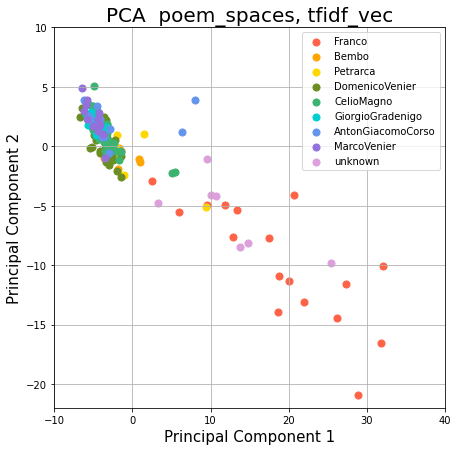

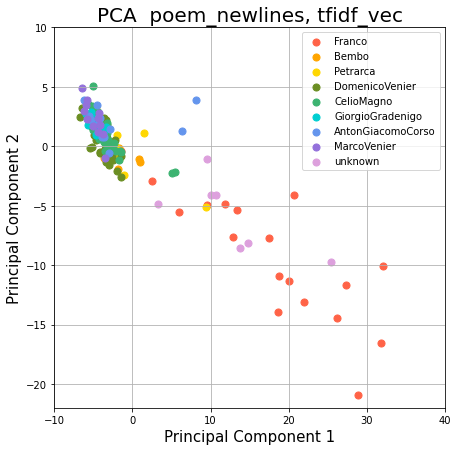

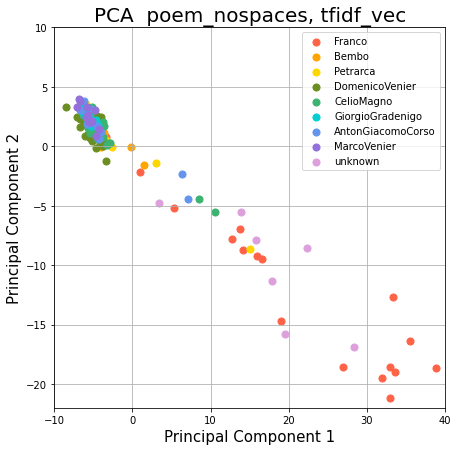

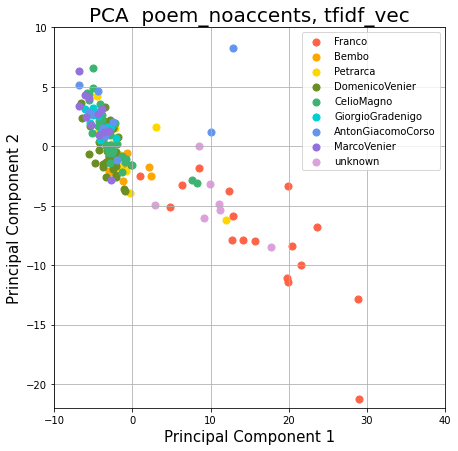

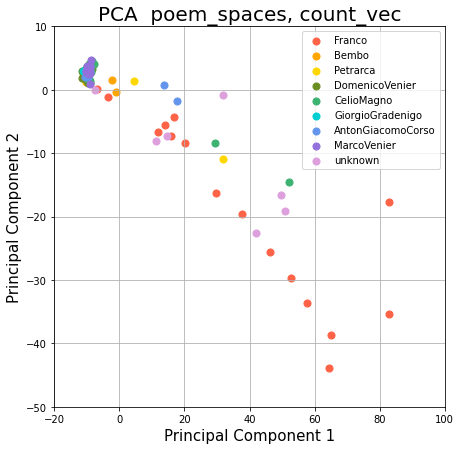

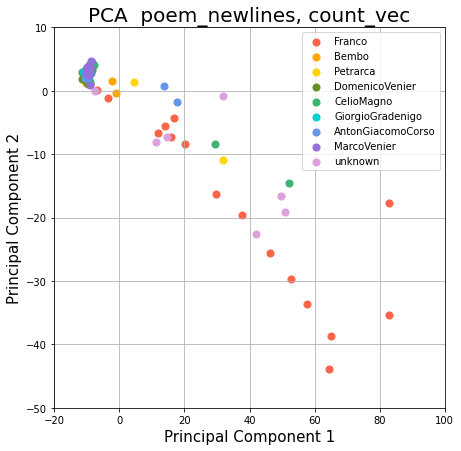

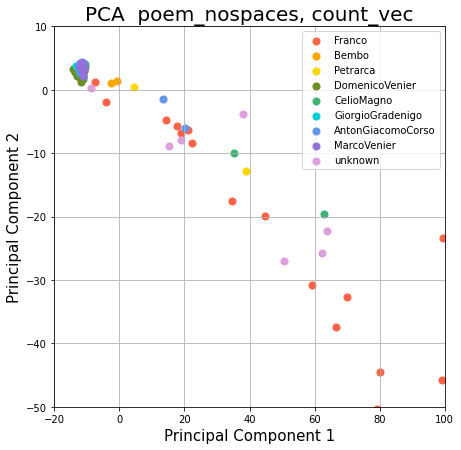

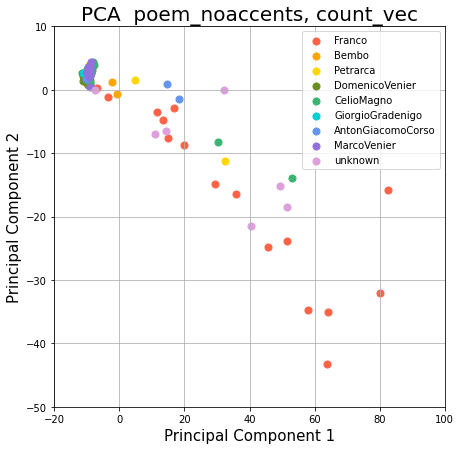

In [ ]:
for key_df in pca_dfs:
  df = pca_dfs[key_df]
  fig = plt.figure(figsize = (7,7))
  ax = fig.add_subplot(1,1,1) 
  targets = df.author.unique()
  colors = ['tomato', 'orange', 'gold', 'olivedrab', 'mediumseagreen', 'darkturquoise', 'cornflowerblue', 'mediumpurple', 'plum']
  for target, color in zip(targets,colors):
      indicesToKeep = df['author'] == target
      ax.scatter(df.loc[indicesToKeep, 'principal component 1']
                , df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
  if 'tfidf' in key_df:
    ax.set_xlim(-10,40)
    ax.set_ylim(-22,10)
  else:
    ax.set_xlim(-20,100)
    ax.set_ylim(-50,10)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(f'PCA  {key_df}', fontsize = 20)
  ax.legend(targets)
  ax.grid()

### Pentagrams

In [ ]:
vectorizers_d = {'tfidf_vec': TfidfVectorizer(
                      input='content',
                      encoding='utf-8',
                      lowercase=True,
                      analyzer='char',  # char_wb to add padding at beggining and end of the string
                      ngram_range=(5, 5)),
                 'count_vec': CountVectorizer(
                      input='content',
                      encoding='utf-8',
                      lowercase=True,
                      analyzer='char',  # char_wb to add padding at beggining and end of the string
                      ngram_range=(5, 5))
         }

In [ ]:
pca_dfs = {}
for vectorizer in vectorizers_d:
  for cleaning_method in poems_df.columns[2:]:
    poems = poems_df[cleaning_method].tolist()
    vec = vectorizers_d[vectorizer]
    X = vec.fit_transform(poems)
    print(vec.get_feature_names_out()[1500:1505])
    X = StandardScaler().fit_transform(X.toarray())
    #print(X[:2])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    principal_df = pd.DataFrame(principal_components, columns = ['principal component 1', 'principal component 2'])
    principal_df['author'] = poems_df['author']
    print(principal_df[:1])

    key = f'{cleaning_method}, {vectorizer}'
    pca_dfs[key] = principal_df

[' gir ' ' gira' ' gire' ' giri' ' girm']
   principal component 1  principal component 2  author
0              -6.479104              -9.689858  Franco
[' cicl' ' ciec' ' ciel' ' cigl' ' cima']
   principal component 1  principal component 2  author
0              -6.475984              -9.022016  Franco
['agnae' 'agnag' 'agnai' 'agnal' 'agnan']
   principal component 1  principal component 2  author
0              -7.541868             -10.457426  Franco
[' ha s' ' ha t' ' ha v' ' habb' ' habi']
   principal component 1  principal component 2  author
0               -6.29951              -9.535279  Franco
[' gir ' ' gira' ' gire' ' giri' ' girm']
   principal component 1  principal component 2  author
0             -14.791556             -12.091324  Franco
[' cicl' ' ciec' ' ciel' ' cigl' ' cima']
   principal component 1  principal component 2  author
0             -14.204141               -11.7859  Franco
['agnae' 'agnag' 'agnai' 'agnal' 'agnan']
   principal component 1  principa

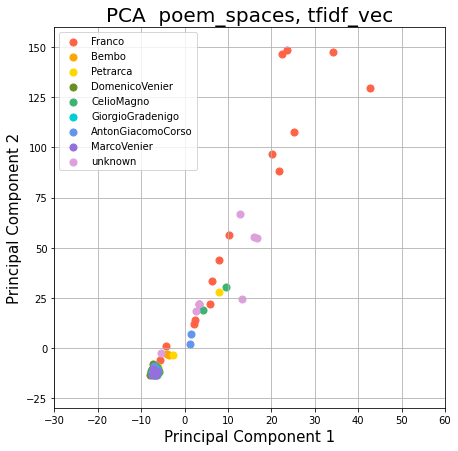

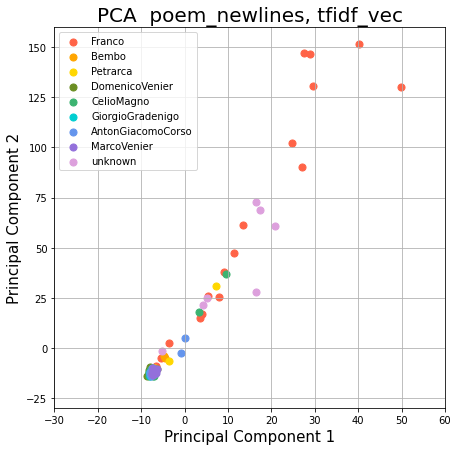

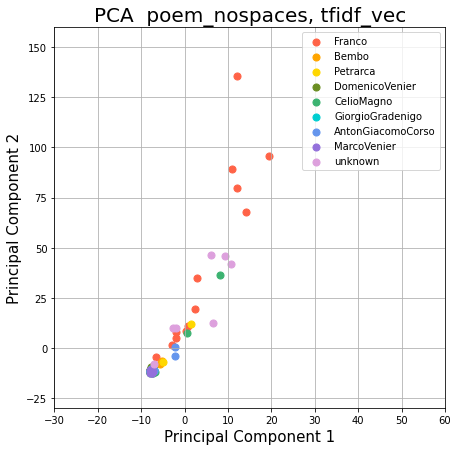

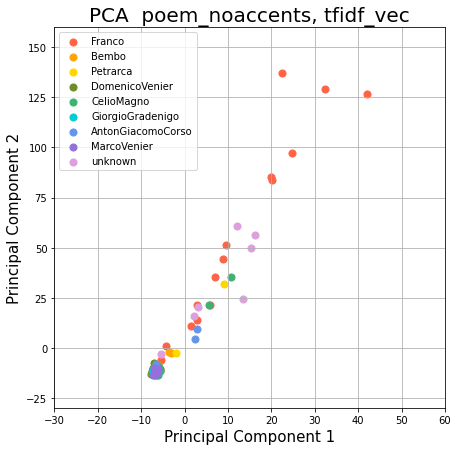

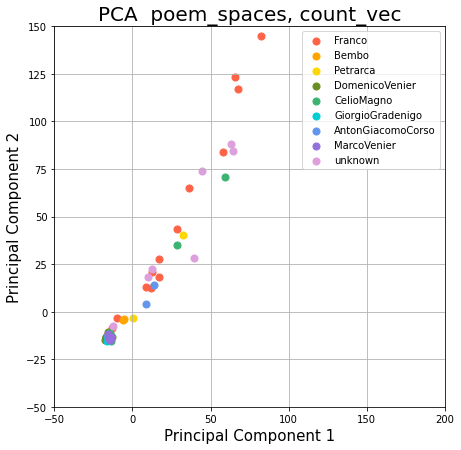

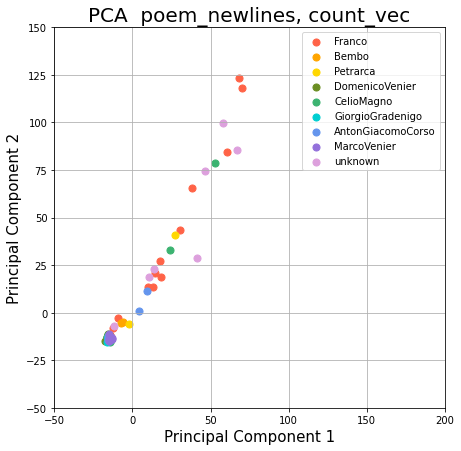

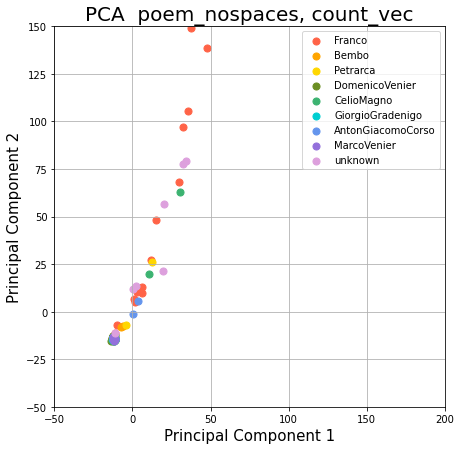

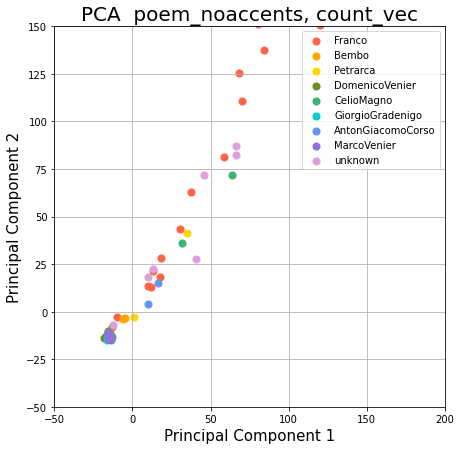

In [ ]:
for key_df in pca_dfs:
  df = pca_dfs[key_df]
  fig = plt.figure(figsize = (7,7))
  ax = fig.add_subplot(1,1,1) 
  targets = df.author.unique()
  colors = ['tomato', 'orange', 'gold', 'olivedrab', 'mediumseagreen', 'darkturquoise', 'cornflowerblue', 'mediumpurple', 'plum']
  for target, color in zip(targets,colors):
      indicesToKeep = df['author'] == target
      ax.scatter(df.loc[indicesToKeep, 'principal component 1']
                , df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
  if 'tfidf' in key_df:
    ax.set_xlim(-30,60)
    ax.set_ylim(-30,160)
  else:
    ax.set_xlim(-50,200)
    ax.set_ylim(-50,150)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(f'PCA  {key_df}', fontsize = 20)
  ax.legend(targets)
  ax.grid()